# COMS W4705 - Homework 4 
## Image Captioning with Conditioned LSTM Generators
Yassine Benajiba <yb2235@cs.columbia.edu>

Follow the instructions in this notebook step-by step. Much of the code is provided, but some sections are marked with **todo**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Write a generator function that returns one training instance (input/output sequence pair) at a time. 
* Train an LSTM language generator on the caption data.
* Write a decoder function for the language generator. 
* Add the image input to write an LSTM caption generator. 
* Implement beam search for the image caption generator.

Please submit a copy of this notebook only, including all outputs. Do not submit any of the data files. 

### Getting Started 

First, run the following commands to make sure you have all required packages. 

In [3]:
!pip install keras

     |████████████████████████████████| 1.4 MB 5.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ecbm4040/envTF24/bin/python3 -m pip install --upgrade pip' command.


In [27]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf


from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

#from google.colab import drive

In [28]:
tf.config.run_functions_eagerly(True)


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

I have uploaded all the data and model files you'll need to my GDrive and you can access the folder here:
https://drive.google.com/drive/folders/1i9Iun4h3EN1vSd1A1woez0mXJ9vRjFlT?usp=sharing

Google Drive does not allow to copy a folder, so you'll need to download the whole folder and then upload it again to your own drive. Please assign the name you chose for this folder to the variable `my_data_dir` in the next cell.

N.B.: Usage of this data is limited to this homework assignment. If you would like to experiment with the data set beyond this course, I suggest that you submit your owndownload request here: https://forms.illinois.edu/sec/1713398

In [2]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
my_data_dir="./hw4_data"

### Mounting your GDrive so you can access the files from Colab

Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

## Part I: Image Encodings (14 pts)

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists. 

In [112]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [113]:
train_list = load_image_list(my_data_dir+'/Flickr_8k.trainImages.txt')
dev_list = load_image_list(my_data_dir+'/Flickr_8k.devImages.txt')
test_list = load_image_list(my_data_dir+'/Flickr_8k.testImages.txt')

Let's see how many images there are

In [114]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [115]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [116]:
IMG_PATH = "./hw4_data/Flickr8k_Dataset"

We can use PIL to open the image and matplotlib to display it. 

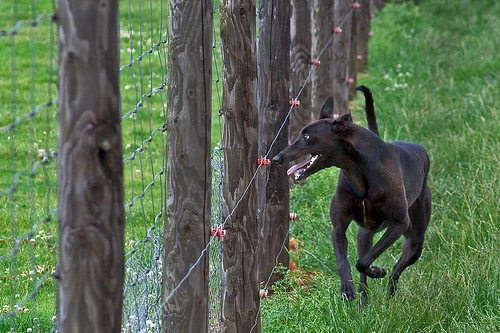

In [117]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

if you can't see the image, try

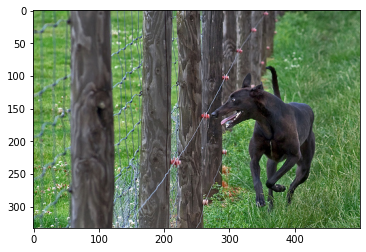

In [118]:
plt.imshow(image)

We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [119]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [120]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

We can use PIL to resize the image and then divide every value by 255. 

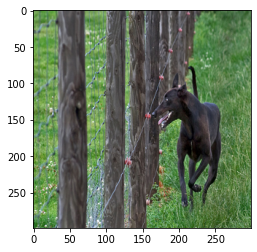

In [121]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [122]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [123]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                      

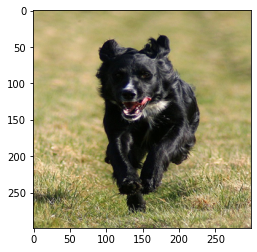

In [124]:
plt.imshow(get_image(dev_list[25]))

Next, we load the pre-trained Inception model. 

In [5]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

In [6]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [29]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [30]:
encoded_image = img_encoder.predict(np.array([new_image]))

In [31]:
encoded_image

array([[0.6380654 , 0.4887303 , 0.05526233, ..., 0.64255756, 0.29595238,
        0.49004295]], dtype=float32)

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, dev, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

In [7]:
def img_generator(img_list):
    
    n = len(img_list)
    i = 0

    while i < n:
        image = PIL.Image.open(os.path.join(IMG_PATH, img_list[i]))
        image_i = np.asarray(image.resize((299,299))) / 255.0    
        yield (np.expand_dims(image_i, axis=0)) 
        i += 1  
    #...
    #yield #...

Now we can encode all images (this takes a few minutes).

In [33]:
enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


6000/6000 [==============================] - 81s 13ms/step


In [211]:
len(enc_train)

6000

In [35]:
enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)

1000/1000 [==============================] - 13s 13ms/step


In [36]:
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

1000/1000 [==============================] - 14s 14ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [37]:
np.save(my_data_dir+"/outputs/encoded_images_train.npy", enc_train)
np.save(my_data_dir+"/outputs/encoded_images_dev.npy", enc_dev)
np.save(my_data_dir+"/outputs/encoded_images_test.npy", enc_test)

## Part II Text (Caption) Data Preparation (14 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. 
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

In [8]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list) 
    
    with open(filename, 'r') as f:
        descriptions = f.readlines()
    for line in descriptions:
        # convert to lower case
        line.lower()
        # split line by white space
        tokens = line.split()
        if len(tokens) < 2:
            continue

        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('#')[0] 
        image_desc = ['<START>']+ image_desc+ ['<END>']
    
        image_descriptions[image_id].append(image_desc)
    # ...
    return image_descriptions

In [9]:
descriptions = read_image_descriptions(my_data_dir+"/Flickr8k.token.txt")

In [10]:
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'Two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'Two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'Two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


Running the previous cell should print:     
`[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. **TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

In [10]:
len(train_list)

6000

In [11]:
t_vocab = {}
i = 0
# there are 6000 items in train_list
while i < 6000: 
    t_descriptions = descriptions[train_list[i]]
    for sen in t_descriptions:
        for word in sen:
            if word not in t_vocab:
                t_vocab[word] = 1
            else:
                t_vocab[word] += 1
    i += 1


In [12]:
len(t_vocab)

8256

In [13]:
word_c = [word for word in t_vocab.items()]
word_c.sort(key=lambda x:x[1], reverse = True)
ix = 0
word_to_id = {}
id_to_word = {}
for w in word_c:
    word_to_id[w[0]] = ix
    id_to_word[ix] = w[0]
    ix += 1

#id_to_word = [word[0] for word in word_c]

In [14]:
#word_to_id = dict([(x, y) for (y, x) in enumerate(id_to_word)])

In [14]:
word_to_id['<END>']

1

In [15]:
word_to_id['dog'] # should print an integer

10

In [16]:
id_to_word[1985] # should print a token

'amongst'

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

## Part III Basic Decoder Model (24 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [26]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [17]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 300)           2476800   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              3330048   
_________________________________________________________________
dense (Dense)                (None, 8256)              8462400   
Total params: 14,269,248
Trainable params: 14,269,248
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

**TODO**: 

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

In [21]:
def text_training_generator(batch_size=128):
    x, y = list(), list()
    count = 0
    while 1:
        for key in train_list:
            desc_list = descriptions[key]
            #count += 1

            # retrieve sentence
            for desc in desc_list:
                seq = [word_to_id[word] for word in desc if word in word_to_id]
                # split sequence into multiple pairs
                for i in range(1, len(seq)):
                    # input + output
                    inp, oup = seq[:i], seq[i]
                    # padding
                    inp = pad_sequences([inp], maxlen=MAX_LEN)[0]
                    oup = to_categorical([oup], num_classes=vocab_size)[0]
                    x.append(inp)
                    y.append(oup)
                    count += 1
                    # batch
                    if count == batch_size:
                        yield(np.array(x), np.array(y))
                          # next batch
                        x, y = list(), list()
                        count = 0


        

    # ... 

### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [22]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [29]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10
   1/1875 [..............................] - ETA: 4:04 - loss: 8.9357 - accuracy: 0.0703

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1875/1875 [==============================] - 124s 66ms/step - loss: 4.0638 - accuracy: 0.3247
Epoch 2/10
1875/1875 [==============================] - 123s 66ms/step - loss: 3.6637 - accuracy: 0.3689
Epoch 3/10
1875/1875 [==============================] - 123s 66ms/step - loss: 3.5173 - accuracy: 0.3812
Epoch 4/10
1875/1875 [==============================] - 123s 66ms/step - loss: 3.4212 - accuracy: 0.3890
Epoch 5/10
1875/1875 [==============================] - 123s 66ms/step - loss: 3.3869 - accuracy: 0.3944
Epoch 6/10
1875/1875 [==============================] - 123s 66ms/step - loss: 3.3042 - accuracy: 0.3999
Epoch 7/10
1875/1875 [==============================] - 123s 65ms/step - loss: 3.2641 - accuracy: 0.4047
Epoch 8/10
1875/1875 [==============================] - 123s 65ms/step - loss: 3.2567 - accuracy: 0.4067
Epoch 9/10
1875/1875 [==============================] - 123s 66ms/step - loss: 3.2311 - accuracy: 0.4107
Epoch 10/10
1875/1875 [==============================] - 123s 65ms

In [31]:
model.save_weights(my_data_dir+"/outputs/model_noimage.h5")

In [ ]:
model.load_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model_noimage.h5")

Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [64]:
from numpy.core.numeric import outer
def decoder():
    in_t = ["<START>"]
    # the sequence reaches MAX_LEN words
    for l in range(MAX_LEN):
        seq = [word_to_id[i] for i in in_t if i in word_to_id]
        seq = pad_sequences([seq], maxlen=MAX_LEN)[0]
        inp = [np.array([seq])]
        oup = model.predict(inp, verbose=0)
        # choose max probability id
        oup = np.argmax(oup)
        # find word
        oup = id_to_word[oup]

        if oup is None: break
        in_t.append(oup)
        # continue until "<END>"
        if oup == "<END>": break

    return in_t

In [65]:
print(decoder())

['<START>', 'A', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'beach', 'with', 'a', 'man', 'in', 'the', 'background', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

In [47]:
x = np.random.multinomial(1, [1/6.]*6, size=1)
x[0]

array([0, 0, 0, 1, 0, 0])

In [60]:
y = np.where(x[0] == 1)

In [61]:
list(y[0])[0]

3

In [96]:
temperature = 1.0
def sample_decoder():
    in_t = ["<START>"]
    # the sequence reaches MAX_LEN words
    for l in range(MAX_LEN):
        seq = [word_to_id[i] for i in in_t if i in word_to_id]
        seq = pad_sequences([seq], maxlen=MAX_LEN)[0]
        inp = [np.array([seq])]
        oup = model.predict(inp, verbose=0)
        # print(oup.shape)
        #print(oup[0])
        # convert probability
        #oup = np.argsort(oup[:,0])
        #oup = oup[::-1]
        #oup = oup[:10]
        #print(oup)
        oup = np.asarray(oup).astype('float64')
        # oup is a probability distribution that was created by applying the 
        # softmax function to the final output(digits)
        # unnormalized digits are supposed to be divided by the temperature
        oup = np.log(oup) / temperature
        exp_oup = np.exp(oup)
        oup = exp_oup / np.sum(exp_oup)
        
        x = np.random.multinomial(1, oup[0,:], size=1)
        y = np.where(x[0] == 1)
        oup = list(y[0])[0]
        # find word
        oup = id_to_word[oup]

        if oup is None: break
        in_t.append(oup)
        # continue until "<END>"
        if oup == "<END>": break

    return in_t

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

In [97]:
for i in range(10): 
    print(sample_decoder())

['<START>', 'The', 'small', 'white', 'dog', 'with', 'his', 'tongue', 'hanging', 'out', 'runs', 'through', 'the', 'grass', '.', '<END>']
['<START>', 'Person', 'in', 'green', 'snow', 'leaves', '<END>']
['<START>', 'A', 'man', 'and', 'woman', 'stand', 'on', 'tap', 'glass', 'down', 'over', 'the', 'beach', 'on', 'the', 'distance', '.', '<END>']
['<START>', 'A', 'boy', 'and', 'girl', 'sitting', 'water', 'near', 'snow', 'has', 'people', 'standing', 'on', 'the', 'edge', 'at', 'the', 'beach', 'on', 'the', 'beach', '.', '<END>']
['<START>', 'An', 'phone', 'and', 'a', 'woman', 'a', 'man', 'in', 'a', 'swimsuit', '<END>']
['<START>', 'A', 'young', 'girl', 'playing', 'with', 'a', 'boy', 'in', 'a', 'red', 'jacket', 'while', 'a', 'woman', 'sits', 'on', 'an', 'the', 'wall', 'of', 'race', 'at', 'it', '.', '<END>']
['<START>', 'two', 'men', 'dogs', 'racing', 'on', 'grass', 'and', 'one', 'white', 'dog', 'to', 'riding', 'on', 'snow', '.', '<END>']
['<START>', 'A', 'sun', 'red', 'pink', 'red', 'yellow', 'ye

## Part III - Conditioning on the Image (24 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [98]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 40, 300)      0           dense_1[0][0]                    
____________________________________________________________________________________________

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

**TODO**: Modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above.  

You need to find the image encoding that belongs to each image. You can use the fact that the index of the image in `train_list` is the same as the index in enc_train and enc_dev. 

If you have previously saved the image encodings, you can load them from disk: 

In [99]:
enc_train = np.load(my_data_dir+"/outputs/encoded_images_train.npy")
enc_dev = np.load(my_data_dir+"/outputs/encoded_images_dev.npy")

In [102]:
np.shape(enc_train[1])

(2048,)

In [103]:
def training_generator(batch_size=128):
    im, x, y = list(), list(), list()
    count = 0
    while 1:
        for i in range(len(train_list)):
            desc_list = descriptions[train_list[i]]
            # retrieve image
            image = enc_train[i]
            # retrieve sentence
            for desc in desc_list:
                seq = [word_to_id[word] for word in desc if word in word_to_id]
                # split sequence into multiple pairs
                for i in range(1, len(seq)):
                    # input + output
                    inp, oup = seq[:i], seq[i]
                    # padding
                    inp = pad_sequences([inp], maxlen=MAX_LEN)[0]
                    oup = to_categorical([oup], num_classes=vocab_size)[0]
                    im.append(image)
                    x.append(inp)
                    y.append(oup)
                    count += 1
                    # batch
                    if count == batch_size:
                        yield ([np.array(im), np.array(x)], np.array(y))
                        im, x, y = list(), list(), list()
                        count = 0

You should now be able to train the model as before: 

In [104]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [106]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 108s 57ms/step - loss: 3.4726 - accuracy: 0.3848
Epoch 2/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.3806 - accuracy: 0.3976
Epoch 3/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.2851 - accuracy: 0.4051
Epoch 4/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.2762 - accuracy: 0.4105
Epoch 5/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.2253 - accuracy: 0.4140
Epoch 6/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.1785 - accuracy: 0.4201
Epoch 7/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.1848 - accuracy: 0.4215
Epoch 8/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.2337 - accuracy: 0.4215
Epoch 9/10
1875/1875 [==============================] - 107s 57ms/step - loss: 3.2221 - accuracy: 0.4221
Epoch 10/10
1875/1875 [==============================] 

Again, continue to train the model until you hit an accuracy of about 40%. This may take a while. I strongly encourage you to experiment with cloud GPUs using the GCP voucher for the class. 

You can save your model weights to disk and continue at a later time. 

In [107]:
model.save_weights(my_data_dir+"/outputs/model.h5")

to load the model: 

In [ ]:
model.load_weights(my_data_dir+"/outputs/model.h5")

**TODO**: Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [184]:
def image_decoder(enc_image): 
    # ...
    in_t = ["<START>"]
    # the sequence reaches MAX_LEN words
    for l in range(MAX_LEN):
        seq = [word_to_id[i] for i in in_t if i in word_to_id]
        seq = pad_sequences([seq], maxlen=MAX_LEN)[0]
        #print(np.shape(seq))
        
        #reshape (2048,) back to (1, 2048)
        enc_image = enc_image.reshape((1,2048))
        inp = [enc_image,np.array([seq])]
        #inp = [np.array([seq])]
        #print(np.shape(inp))
        #enc_image = np.array(enc_image)
        oup = model.predict(inp, verbose=0)
        
        # choose max probability id
        oup = np.argmax(oup)
        # find word
        # find word
        
        oup = id_to_word[oup]

        if oup is None: break
        in_t.append(oup)
        # continue until "<END>"
        if oup == "<END>": break

    return in_t
    

As a sanity check, you should now be able to reproduce (approximately) captions for the training images. 

In [185]:
np.array(enc_train[0])

array([0.1037339 , 0.25207853, 0.07683969, ..., 0.17885208, 1.6637325 ,
       0.56516266], dtype=float32)

['<START>',
 'A',
 'brown',
 'dog',
 'is',
 'running',
 'through',
 'the',
 'snow',
 '.',
 '<END>']

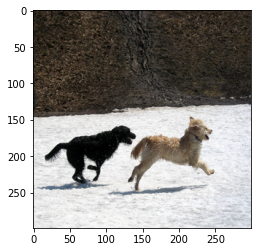

In [186]:
plt.imshow(get_image(train_list[0]))
image_decoder(enc_train[0])

You should also be able to apply the model to dev images and get reasonable captions:

['<START>',
 'A',
 'man',
 'in',
 'a',
 'red',
 'shirt',
 'is',
 'riding',
 'a',
 'skateboard',
 'down',
 'the',
 'street',
 '.',
 '<END>']

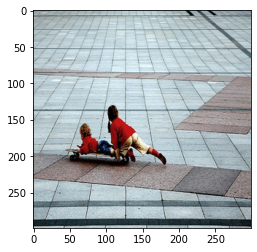

In [220]:
plt.imshow(get_image(dev_list[0]))
image_decoder(enc_dev[0])

For this assignment we will not perform a formal evaluation. 

Feel free to experiment with the parameters of the model or continue training the model. At some point, the model will overfit and will no longer produce good descriptions for the dev images. 

## Part IV - Beam Search Decoder (24 pts)

**TODO** Modify the simple greedy decoder for the caption generator to use beam search. 
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences. 

Then, for each sequence, compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates. 

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated. 

Note that you cannot use the occurence of the `"<END>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam. 

Once `MAX_LEN` has been reached, return the most likely sequence out of the current n. 

In [ ]:
sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         

In [207]:
def img_beam_decoder(n, image_enc):
    in_t = [word_to_id["<START>"]]
    start = [[in_t, 0.0]]
    while len(start[0][0]) < MAX_LEN:
        temp = []
        for s in start:
            # dont use padding='post' which would cause problem in the results
            seq = pad_sequences([s[0]], maxlen=MAX_LEN).reshape((1, MAX_LEN))
            # print(np.shape(seq))
            # structure input
            image_enc = image_enc.reshape((1,2048))
            inp = [image_enc,seq]

            oup = model.predict(inp, verbose=0)
            
            # n most likely successor words
            word_oup = np.argsort(oup[0])[-n:]
            for w in word_oup:
                cur_seq, prob = s[0][:], s[1]
                cur_seq.append(w)
                # actually I find out that there is no obvious difference
                # between whether using log to process the prob or not
                prob += np.log(oup[0][w])
                temp.append([cur_seq, prob])

        start = temp
        start = sorted(start, key=lambda x:x[1], reverse=True)
        # reserve top n 
        start = start[:n]
        # print(start)
    
    start = start[0][0]
    #print(start)
    path = [id_to_word[i] for i in start]
    res = []

    for i in path:
        if i != '<END>':
            res.append(i)
        else:
            break

    return res



['<START>',
 'A',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'black',
 'pants',
 'is',
 'standing',
 'on',
 'the',
 'street',
 '.']

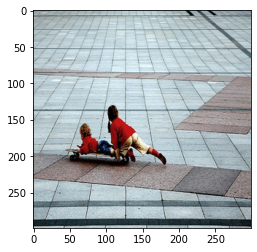

In [221]:
plt.imshow(get_image(dev_list[0]))
img_beam_decoder(3, enc_dev[0])

**TODO** Finally, before you submit this assignment, please show 5 development images, each with 1) their greedy output, 2) beam search at n=3 3) beam search at n=5. 

Greedy Output: ['<START>', 'A', 'group', 'of', 'people', 'stand', 'on', 'the', 'street', '.', '<END>']
Beam Search with n=3: ['<START>', 'A', 'group', 'of', 'people', 'stand', 'on', 'the', 'street', '.']
Beam Search with n=5: ['<START>', 'A', 'group', 'of', 'people', 'stand', 'in', 'front', 'of', 'a', 'building', '.']


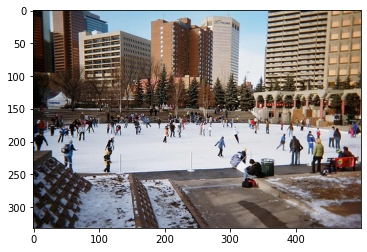

In [230]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[6]))
image_en = enc_dev[6]
plt.imshow(image)
print("Greedy Output:", image_decoder(image_en))
print("Beam Search with n=3:", img_beam_decoder(3, image_en))
print("Beam Search with n=5:", img_beam_decoder(5, image_en))


Greedy Output: ['<START>', 'A', 'man', 'in', 'a', 'red', 'jacket', 'is', 'standing', 'on', 'the', 'grass', 'with', 'his', 'arms', 'out', 'of', 'the', 'other', '.', '<END>']
Beam Search with n=3: ['<START>', 'A', 'man', 'in', 'a', 'red', 'jacket', 'is', 'standing', 'on', 'the', 'grass', '.']
Beam Search with n=5: ['<START>', 'A', 'man', 'in', 'a', 'red', 'jacket', 'is', 'standing', 'in', 'front', 'of', 'a', 'white', 'building', '.']


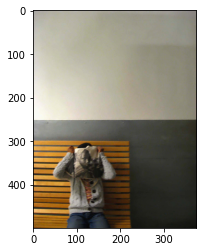

In [222]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[22]))
image_en = enc_dev[22]
plt.imshow(image)
print("Greedy Output:", image_decoder(image_en))
print("Beam Search with n=3:", img_beam_decoder(3, image_en))
print("Beam Search with n=5:", img_beam_decoder(5, image_en))

Greedy Output: ['<START>', 'A', 'black', 'and', 'white', 'dog', 'is', 'biting', 'a', 'stick', 'in', 'the', 'snow', '.', '<END>']
Beam Search with n=3: ['<START>', 'Two', 'dogs', 'play', 'in', 'the', 'snow', '.']
Beam Search with n=5: ['<START>', 'Two', 'dogs', 'play', 'in', 'the', 'grass', '.']


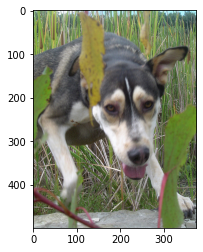

In [224]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[33]))
image_en = enc_dev[33]
plt.imshow(image)
print("Greedy Output:", image_decoder(image_en))
print("Beam Search with n=3:", img_beam_decoder(3, image_en))
print("Beam Search with n=5:", img_beam_decoder(5, image_en))

Greedy Output: ['<START>', 'A', 'brown', 'and', 'white', 'dog', 'is', 'biting', 'a', 'ball', 'in', 'the', 'park', '.', '<END>']
Beam Search with n=3: ['<START>', 'A', 'brown', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'grass', '.']
Beam Search with n=5: ['<START>', 'A', 'brown', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'grass', '.']


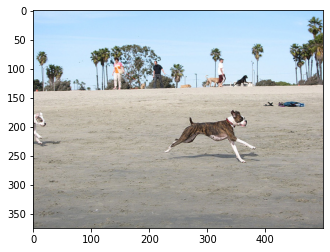

In [227]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[66]))
image_en = enc_dev[66]
plt.imshow(image)
print("Greedy Output:", image_decoder(image_en))
print("Beam Search with n=3:", img_beam_decoder(3, image_en))
print("Beam Search with n=5:", img_beam_decoder(5, image_en))

Greedy Output: ['<START>', 'Two', 'dogs', 'run', 'through', 'the', 'snow', '.', '<END>']
Beam Search with n=3: ['<START>', 'Two', 'dogs', 'play', 'in', 'the', 'snow', '.']
Beam Search with n=5: ['<START>', 'Two', 'dogs', 'play', 'in', 'the', 'snow', '.']


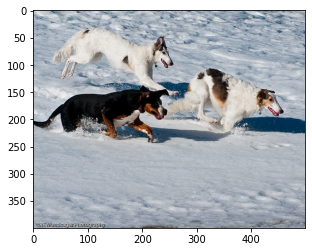

In [228]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[88]))
image_en = enc_dev[88]
plt.imshow(image)
print("Greedy Output:", image_decoder(image_en))
print("Beam Search with n=3:", img_beam_decoder(3, image_en))
print("Beam Search with n=5:", img_beam_decoder(5, image_en))